# Library
---

In [1]:
# default
from pprint import pprint
import natsort
import os, sys
import json
import pickle as pkl
from tqdm import notebook

# data structure
import numpy as np
from PIL import Image

# visualize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
import cv2

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Deep Learning
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision.models import resnet50
from torchvision.models import efficientnet_v2_s, efficientnet_v2_m, efficientnet_v2_l

In [2]:
TRAIN = 0
VALID = 1
data_type = ["train", "valid"]
dt = data_type[TRAIN]

project_path = "E:/Tukorea/Capstone/"
original_data_path = os.path.join(project_path, "dataset/", "original/", f"{dt}/")
RoI_data_path = os.path.join(project_path, "dataset/", "RoI/", f"{dt}/")
background_RoI_data_path = os.path.join(project_path, "dataset/", "background_RoI/", f"{dt}/")
box_data_path = os.path.join(project_path, "dataset/", "box/256x256/", f"{dt}/")
crop_data_path = os.path.join(project_path, "dataset/", "crop/", f"{dt}/")
RZ_data_path = os.path.join(project_path, "dataset/", "ratio_zero-padding/", f"{dt}/")
RZ_LANCZOS4_data_path = os.path.join(project_path, "dataset/", "RZ_LANCZOS4/", f"{dt}/")

data_path_namelist = ["original", "RoI", "background_RoI", "box", "crop", "ratio_zero-padding", "RZ_LANCZOS4"]
data_path_list = [original_data_path, RoI_data_path, background_RoI_data_path, box_data_path, crop_data_path, RZ_data_path, RZ_LANCZOS4_data_path]

print("DATA TYPE:", dt, end="\n\n")
for i, data_path in enumerate(data_path_list):
    print(data_path_namelist[i] + " data folder")
    folder = natsort.natsorted(os.listdir(data_path))
    print(folder, end="\n\n")

DATA TYPE: train

original data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

RoI data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

background_RoI data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

box data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

crop data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

ratio_zero-padding data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']

RZ_LANCZOS4 data folder
['A1', 'A2', 'A3', 'A4', 'A5', 'A6']



# Extract data
---

In [49]:
# fuctions
def to_excel(path, excel_information: dict):
    pd.DataFrame.from_dict(excel_information).to_csv(path)
    return

def extract_info_json(original_data_path, project_path, data_dict: dict, data_type: str = "train"):
    # json 정보 추출 단계
    # to_excel + inspRejectYn
    # to_RoI
    excel_information = dict()
    excel_information["exist"] = list()

    labels = data_dict.keys()
    for label in labels:
        datas = data_dict[label]
        try:    os.mkdir(project_path + f"RoI_data/{data_type}/" + (label + "/"))
        except: print("what?")

        jsons = datas[1]
        for json_file in jsons:
            file_path = (original_data_path + label + "/") + json_file
            data = json.load(open(file_path))
            
            if "x" not in excel_information: excel_information["x"] = list()
            if "y" not in excel_information: excel_information["y"] = list()
            if "width" not in excel_information: excel_information["width"] = list()
            if "height" not in excel_information: excel_information["height"] = list()

            # labelingInfo: 관심영역 (polygon, box)
            image_name = json_file.split(".")[0] + ".jpg"
            image_path = original_data_path + (label + "/") + image_name
            labeling_Info = data["labelingInfo"]
            info_length = len(labeling_Info)
            if info_length > 2:
                # length is always even
                for i, RoI_info in enumerate(labeling_Info):
                    if "box" not in RoI_info: break
                    RoI = RoI_info["box"]["location"][0]
                    sx, ex = RoI["x"], RoI["x"] + RoI["width"]
                    sy, ey = RoI["y"], RoI["y"] + RoI["height"]
                    
                    # metaData: 정형 데이터
                    # inspRejectYn: 반려 여부
                    mData = data["metaData"]
                    for key, value in mData.items():
                        if key not in excel_information:
                            excel_information[key] = list()
                        excel_information[key].append(value)

                    inspReject = data["inspRejectYn"]
                    if "inspRejectYn" not in excel_information: excel_information["inspRejectYn"] = list()
                    excel_information["inspRejectYn"].append(inspReject)

                    # 엑셀 저장용
                    # 이미지가 없어도 엑셀 데이터는 저장한다.
                    excel_information["x"].append(sx)
                    excel_information["y"].append(sy)
                    excel_information["width"].append(RoI["width"])
                    excel_information["height"].append(RoI["height"])

                    # RoI 박스 크기가 0이 아니라면
                    # 이미지가 존재 한다면
                    if ((sx != ex and sy != ey) and (os.path.exists(image_path))):
                        image = cv2.imread(image_path)
                        image_name = json_file.split(".")[0] + "T" + str(i) + ".jpg"
                        save_path = project_path + f"RoI_data/{data_type}/" + (label + "/") + image_name
                        cv2.imwrite(save_path, image[sy:ey, sx:ex])
                        excel_information["exist"].append("Y")
                    else:
                        excel_information["exist"].append("N")

            else:
                polygon = labeling_Info[0]
                RoI = labeling_Info[1]["box"]["location"][0]
                # swap
                if "box" in polygon:
                    temp = RoI
                    RoI = polygon
                    polygon = temp
                
                sx, ex = RoI["x"], RoI["x"] + RoI["width"]
                sy, ey = RoI["y"], RoI["y"] + RoI["height"]
                
                # metaData: 정형 데이터
                # inspRejectYn: 반려 여부
                mData = data["metaData"]
                for key, value in mData.items():
                    if key not in excel_information:
                        excel_information[key] = list()
                    excel_information[key].append(value)

                inspReject = data["inspRejectYn"]
                if "inspRejectYn" not in excel_information: excel_information["inspRejectYn"] = list()
                excel_information["inspRejectYn"].append(inspReject)

                # 엑셀 저장용
                excel_information["x"].append(sx)
                excel_information["y"].append(sy)
                excel_information["width"].append(RoI["width"])
                excel_information["height"].append(RoI["height"])
                
                # 관심 영역이 0이거나, 파일이 없다면
                if ((sx != ex and sy != ey) and (os.path.exists(image_path))):
                    image = cv2.imread(image_path)
                    cv2.imwrite(project_path + f"RoI_data/{data_type}/" + (label + "/") + image_name, image[sy:ey, sx:ex])
                    excel_information["exist"].append("Y")
                else:
                    excel_information["exist"].append("N")
        
        to_excel(project_path + label + ".csv", excel_information)
        excel_information = dict()
        excel_information["exist"] = list()
        break
    return

In [47]:
# data_dict 구성
# key: label name
# value: tuple(jpgs: image name list, jsons: json name list)

data_dict = dict()
for folder in data_folders:
    datas = natsort.natsorted(os.listdir(original_data_path + folder))
    jpgs = [data_file_name for data_file_name in datas if "jpg" in data_file_name]
    jsons = [data_file_name for data_file_name in datas if "json" in data_file_name]

    data_dict[folder] = (jpgs, jsons)

In [46]:
original_data_path

'D:/Capstone/data/valid/original/'

In [39]:
project_path

'D:/Capstone/'

In [21]:
data_type[TRAIN]

'train'

In [45]:
original_data_path = os.path.join(project_path, "data/", f"{data_type[VALID]}/", "original/")

In [50]:
# csv, RoI 추출
extract_info_json(original_data_path, project_path, data_dict, data_type=data_type[VALID])

    A1: 구진, 플라크
    A2: 비듬, 각질, 상피성잔고리
    A3: 태선화, 과다색소침착
    A4: 농포, 여드름
    A5: 미란, 궤양
    A6: 결절, 종괴

    

# Create Dataset
---

In [4]:
def get_RoI_range_csv(size: int, csv_file: pd.DataFrame) -> pd.DataFrame:
    result_csv = csv_file.loc[csv_file.loc[csv_file["width"] <= size].index].copy()
    result_csv = result_csv.loc[result_csv.loc[result_csv["width"] >= 10].index]
    result_csv = result_csv.loc[result_csv.loc[result_csv["height"] <= size].index]
    result_csv = result_csv.loc[result_csv.loc[result_csv["height"] >= 10].index]
    return result_csv

def create_asymptomatic_data(size, gap, csv_files, original_data_path, project_path, data_type):
    for i, csv_file in enumerate(csv_files):
        size_csv = get_RoI_range_csv(size, csv_file)
        
        for index in size_csv.index:
            row = size_csv.loc[index]
            resX, resY = row["resolution"].split("X")
            resX, resY = int(resX), int(resY)
            
            sx, ex = row["x"], row["x"] + row["width"]
            sy, ey = row["y"], row["y"] + row["height"]
            cx, cy = (sx+ex)/2, (sy+ey)/2

            newX, newY = -1, -1
            # 관심영역 중앙 x점이 해상도의 절반 기준으로 어느 위치에 있느냐에 따라 left, right를 정한다.
            if (cx < resX): newX = ex + gap                  # Right
            else:           newX = sx - (gap + row["width"]) # Left

            # 관심영역 중앙 y점이 해상도의 절반 기준으로 어느 위치에 있느냐에 따라 up, down을 정한다.
            if (cy < resY): newY = ey + gap                   # Down
            else:           newY = sy - (gap + row["height"]) # Up

            # 좌표가 해상도 안에 있다면 (newX, newY가 양수)
            if ((newX >= 0 and newY >= 0) and (newX <= resX and newY <= resY)):
                endX, endY = newX + row["width"], newY + row["height"]
                
                # endX, Y가 해상도 안에 있다면 이미지를 생성한다.
                if (endX <= resX and endY <= resY):
                    file_name = row["Raw data ID"].split("_")[-1]
                    image_name = f"IMG_D_A{i+1}_{file_name}"
                    image_path = os.path.join(original_data_path, f"A{i+1}/")
                    image = cv2.imread(image_path + image_name)

                    save_path = os.path.join(project_path, "data/", f"{data_type}/", "asymptomatic/", f"A{i+1}/")
                    try:    os.mkdir(save_path)
                    except: pass
                    cv2.imwrite(save_path + image_name, image[newY:endY, newX:endX])

                # endX, Y가 해상도 안에 없는 상태이며, 넘긴다.
                else:
                    continue
    return

In [108]:
csv_path = os.path.join(project_path, "data/", "csv/")
csv_files = [pd.read_csv(csv_path + f"A{i}.csv", encoding='ANSI') for i in range(1, 7)]
csv_order = np.array(['Raw data ID', 'resolution', 'x', 'y', 'width', 'height', 'breed', 'age', 'gender', 'region', 'lesions'])
for i, csv_file in enumerate(csv_files):
    csv_files[i] = csv_files[i].loc[csv_files[i]["exist"] == "Y"].copy()
    csv_files[i] = csv_files[i].drop_duplicates("Raw data ID", keep=False).copy()
    csv_files[i] = csv_files[i][csv_order].copy()

# EDA
---

## Result
    1. 레이블별 해상도 체크: 모두 1920x1080이 아님 
    2. 너무 작은 width, height를 가지는 데이터들은 제외됨
    3. 관심영역의 크기가 편차가 심함, 256, 384, 512로 먼저 생성
        - 이후 그래픽카드 가용 메모리에 따라 조정
        - 카메라 구도에 따른 (1)입력 이미지 해상도 축소와 늘리는 방법, (2)제로 패딩 시도 해봐야 함
        - 카메라 해상도가 다를 때 사용하는 기술들의 논문 찾기 필요
        - 이미지 전처리 방법 적용 방안 (논문 참고)
    4. 제외된 이미지들이 있으며, 해당 이미지들은 매우 가까이서 찍은 사진들로 따로 추출이 필요할 수 있음
    5. PCA, TSNE

# Preprocessing
---

In [5]:
# csv_files: pd.DataFrame list
# project_path, original_data_path: project and data folder path
def get_RoI_box_image(size: int, csv_files: list, project_path: str, original_data_path: str, data_type: str = "train") -> None:
    try:    os.mkdir(f"{project_path}box_data/{size}x{size}/{data_type}/")
    except: pass
    
    for i, csv_file in enumerate(csv_files):
        # size: 256, 384, 512
        try:    os.mkdir(f"{project_path}box_data/{size}x{size}/{data_type}/A{i + 1}/")
        except: pass

        size_csv = get_RoI_range_csv(size, csv_file)
        count = 0
        last_image_name = ""
        for index in size_csv.index:
            x1, y1 = size_csv.loc[index][["x", "y"]]
            width, height = size_csv.loc[index][["width", "height"]]
            x2, y2 = x1 + width, y1 + height
            center_x = round((x1 + x2 -1) / 2)
            center_y = round((y1 + y2 -1) / 2)

            sX, eX = center_x - (size // 2), center_x + (size // 2)
            sY, eY = center_y - (size // 2), center_y + (size // 2)
            resX, resY = tuple(size_csv.loc[index]["resolution"].split("X"))
            resX, resY = int(resX), int(resY)
            if (sX < 0):      sX, eX = 0, size
            elif (eX > resX): sX, eX = resX - size, resX
            if (sY < 0):      sY, eY = 0, size
            elif (eY > resY): sY, eY = resY - size, resY

            image_name = size_csv.loc[index]["Raw data ID"].split("_")[-1]
            img = cv2.imread(f"{original_data_path}A{i + 1}/IMG_D_A{i + 1}_{image_name}")
            # 이미지 파일이 없을 경우 except
            try:    crop_img = img[sY:eY, sX:eX]
            except: continue

            # 중복된 이미지 파일 이름 행 존재 (다른 관심 영역)
            if (last_image_name == image_name):
                count += 1
                save_path = f"{project_path}box_data/{size}x{size}/{data_type}/A{i + 1}/{count}_{image_name}"
            else:
                count = 0
                save_path = f"{project_path}box_data/{size}x{size}/{data_type}/A{i + 1}/{count}_{image_name}"

            cv2.imwrite(save_path, crop_img)
            last_image_name = image_name
    return

In [51]:
csv_files = [pd.read_csv(project_path + "A" + str(i) + ".csv", encoding='ANSI') for i in range(1, 7)]
csv_order = np.array(['Raw data ID', 'resolution', 'exist', 'x', 'y', 'width', 'height', 'breed', 'age', 'gender', 'region', 'lesions'])
for i, csv_file in enumerate(csv_files):
    csv_files[i] = csv_file[csv_order]

In [52]:
get_RoI_box_image(224, csv_files, project_path, original_data_path, data_type[VALID])

In [ ]:
size = 224, 224
image_path = os.path.join(project_path, "RoI_data", data_type) #이미지 경로
modified_path = os.path.join(project_path, "Ratio_data", data_type)
os.chdir(image_path)

def resize_and_crop(image_path, modified_path, size, crop_type='middle'):
    files = os.listdir(image_path)
    try:    os.mkdir(modified_path)
    except: pass

    for file in files:
        name = str(file)
        os.chdir(image_path)
        img = Image.open(file)
        img_ratio = img.size[0] / float(img.size[1])
        ratio = size[0] / float(size[1])
        
        if ratio > img_ratio:
            img = img.resize((size[0], int(round(size[0] * img.size[1] / img.size[0]))),
                Image.ANTIALIAS)     
            if crop_type == 'top':
                box = (0, 0, img.size[0], size[1])
            elif crop_type == 'middle':
                box = (0, int(round((img.size[1] - size[1]) / 2)), img.size[0],
                    int(round((img.size[1] + size[1]) / 2)))
            elif crop_type == 'bottom':
                box = (0, img.size[1] - size[1], img.size[0], img.size[1])
            else :
                raise ValueError('ERROR: invalid value for crop_type')
            img = img.crop(box)
            
        elif ratio < img_ratio:
            img = img.resize((int(round(size[1] * img.size[0] / img.size[1])), size[1]),
                Image.ANTIALIAS)
            if crop_type == 'top':
                box = (0, 0, size[0], img.size[1])
            elif crop_type == 'middle':
                box = (int(round((img.size[0] - size[0]) / 2)), 0,
                    int(round((img.size[0] + size[0]) / 2)), img.size[1])
            elif crop_type == 'bottom':
                box = (img.size[0] - size[0], 0, img.size[0], img.size[1])
            else :
                raise ValueError('ERROR: invalid value for crop_type')
            img = img.crop(box)
            
        else :
            img = img.resize((size[0], size[1]), Image.ANTIALIAS)
            
        os.chdir(modified_path)
        img.save(name, "JPEG")

for folder in os.listdir(image_path):
    resize_and_crop(os.path.join(image_path, folder), os.path.join(modified_path, folder), size)

C:\Users\bang\AppData\Local\Temp\ipykernel_13232\1389602285.py:34: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  Image.ANTIALIAS)
C:\Users\bang\AppData\Local\Temp\ipykernel_13232\1389602285.py:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((size[0], size[1]), Image.ANTIALIAS)
C:\Users\bang\AppData\Local\Temp\ipykernel_13232\1389602285.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  Image.ANTIALIAS)


In [6]:
def ratio_resize_and_zeroPadding(size, RoI_data_path, RZ_data_path):
    for label in natsort.natsorted(os.listdir(RoI_data_path)):
        folder_path = os.path.join(RoI_data_path, f"{label}/")
        img_filenames = natsort.natsorted(os.listdir(folder_path))

        for img_filename in img_filenames:
            result = np.zeros((size, size, 3), np.uint8)
            image = cv2.imread(folder_path + img_filename, cv2.IMREAD_COLOR)
            
            h, w = image.shape[:2]
            ash = size / h
            asw = size / w
            if asw < ash: sizeas = (int(w*asw), int(h*asw))
            else:         sizeas = (int(w*ash), int(h*ash))
            image = cv2.resize(image, dsize=sizeas)

            sx, ex = int(size/2 - sizeas[1]/2), int(size/2 + sizeas[1]/2)
            sy, ey = int(size/2 - sizeas[0]/2), int(size/2 + sizeas[0]/2)
            result[sx:ex, sy:ey, :] = image

            try:    os.mkdir(RZ_data_path + label)
            except: pass
            save_path = os.path.join(RZ_data_path, f"{label}/")
            cv2.imwrite(save_path + img_filename, result)
    return

In [7]:
# 라이브러리 import 
size = 224
RoI_data_path = os.path.join(project_path, "RoI_data/", f"{data_type[VALID]}/")
RZ_data_path = os.path.join(project_path, "RZ_data/", f"{data_type[VALID]}/")
ratio_resize_and_zeroPadding(size, RoI_data_path, RZ_data_path)

# Simple Deep Learning
---

## Create dataset using pickle

In [5]:
def convert_PIL_to_numpy(images):
    return np.array([cv2.merge(list(cv2.split(np.uint8(image))[::-1])) for image in images])

def convert_PIL_to_tensor(images):
    to_tensor = torchvision.transforms.ToTensor()      
    return torch.stack([to_tensor(PIL_image) for PIL_image in images], dim=0)

def convert_numpy_to_PIL(images):
    return [Image.fromarray(cv2.merge(list(cv2.split(image)[::-1]))) for image in images]

def convert_numpy_to_tensor(images):
    return convert_PIL_to_tensor(convert_numpy_to_PIL(images))

def convert_tensor_to_PIL(tensors):
    to_PIL = torchvision.transforms.ToPILImage()    
    return [to_PIL(tensor) for tensor in tensors]

def convert_tensor_to_numpy(tensors):
    return convert_PIL_to_numpy(convert_tensor_to_PIL(tensors))

In [6]:
data_type

['train', 'valid']

In [5]:
labels = ["A1", "A2", "A3", "A4", "A5", "A6"]

In [7]:
# data_path = "/".join(background_RoI_data_path.split("/")[:-2]) + "/valid_90p/"
data_path = "/".join(original_data_path.split("/")[:-1]) + "/"
print(data_path)

E:/Tukorea/Capstone/dataset/original/train/


In [8]:
label_dict = {"A1": 0, "A2": 1, "A3": 2, "A4": 3, "A5": 4, "A6": 5}

x = list()
y = list()
for label in labels:
    label_path = f"{data_path}{label}/"
    image_names = os.listdir(label_path)

    for image_name in image_names:
        img = cv2.imread(label_path + image_name)
        x.append(img)
        y.append(label_dict[label])
x = np.array(x)
y = np.array(y)

: 

: 

In [22]:
PIL_x = convert_numpy_to_PIL(x)

In [23]:
with open(f"E:/Tukorea/Capstone/dataset/background_RoI/valid_90p.pkl", "wb") as pkl_file:
    pkl.dump((PIL_x, y), pkl_file)

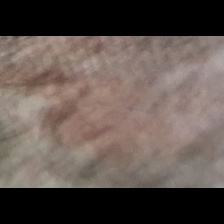

In [22]:
PIL_x[0]

## Open dataset

In [4]:
size = 224
project_path = "D:/Capstone/"

# 이미지 불러오기
with open(os.path.join(project_path, "total_224x224_train_PIL_data.pkl"), "rb") as pkl_file:
  train_x, train_y = pkl.load(pkl_file)

with open(os.path.join(project_path, "total_224x224_valid_PIL_data.pkl"), "rb") as pkl_file:
  valid_x, valid_y = pkl.load(pkl_file)

  '''
# 이미지 불러오기
with open(os.path.join(project_path, "box_224x224_train_PIL_data.pkl"), "rb") as pkl_file:
  train_x, train_y = pkl.load(pkl_file)

with open(os.path.join(project_path, "box_224x224_valid_PIL_data.pkl"), "rb") as pkl_file:
  valid_x, valid_y = pkl.load(pkl_file)
  '''

In [5]:
print("train_x length: ", len(train_x))
print("train_x type: ", type(train_x))
print("train_y length: ", train_y.shape)
print("train_y type: ", type(train_y))
print("valid_x length: ", len(valid_x))
print("valid_x type: ", type(valid_x))
print("valid_y length: ", valid_y.shape)
print("valid_y type: ", type(valid_y))

train_x length:  53436
train_x type:  <class 'list'>
train_y length:  (53436,)
train_y type:  <class 'numpy.ndarray'>
valid_x length:  6644
valid_x type:  <class 'list'>
valid_y length:  (6644,)
valid_y type:  <class 'numpy.ndarray'>


In [6]:
class Skin_Disease_Dataset(Dataset):
  def __init__(self, x, y, transforms):
    self.x = x
    self.y = y
    self.transforms = transforms

  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, index: int):
    image = self.x[index]
    target = self.y[index].astype(np.float32)

    if self.transforms is not None:
        image = self.transforms(image)

    return image, target

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [8]:
train_dataset = Skin_Disease_Dataset(train_x, train_y, train_transforms)
valid_dataset = Skin_Disease_Dataset(valid_x, valid_y, test_transforms)
train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

## ResNet18
---

In [98]:
ROW = 0
COLUMN = 1

class Skin_Distinction_Model(nn.Module):
    def __init__(self, device, save_path):
        # 모델 부분
        super().__init__()
        
        # 2-class
        self.resnet18 = models.resnet18(weights='IMAGENET1K_V1')
        self.output = torch.nn.Linear(1000, 6)
        
        self.device = device
        self.save_path = save_path
        self.history = {"train_loss": list(),
                        "valid_loss": list(),
                        "train_acc": list(),
                        "valid_acc": list()}
        self.best_loss = None
        self.best_acc = None

    def forward(self, x):
        x = self.resnet18(x)
        x = self.output(x)
        return x
    
    def fit(self, parameters):
        train_DataLoader = parameters["Train_DataLoader"]
        valid_DataLoader = parameters["Valid_DataLoader"]
        optimizer        = parameters["Optimizer"]
        criterion        = parameters["Loss_function"]
        epochs           = parameters['Epochs']

        for epoch in notebook.tqdm(range(epochs)):
            self.train(True)
            print("Epoch: %d/%d" % (epoch + 1, epochs))

            # train part
            batch_train_loss, batch_train_acc = list(), list()
            for i, (images, targets) in enumerate(train_DataLoader):
                optimizer.zero_grad()
                
                # cuda images, targets
                targets = targets.type(torch.LongTensor)
                images = images.to(self.device)
                targets = targets.to(self.device)

                # predict
                outputs = self(images)
                train_loss = criterion(outputs, targets)

                # backprop
                train_loss.backward()
                optimizer.step()

                value, labels = torch.max(outputs.data, dim=COLUMN)
                batch = targets.size(dim=ROW)
                train_acc = (labels == targets).sum().item() / batch * 100
                batch_train_loss.append(train_loss.item())
                batch_train_acc.append(train_acc)
            
            # train, valid loss, acc 검증 및 저장
            tlv = sum(batch_train_loss) / len(batch_train_loss)
            tav = sum(batch_train_acc) / len(batch_train_acc)
            self.history["train_loss"].append(tlv)
            self.history["train_acc"].append(tav)
            print("Train - Loss: %.6f, Accuracy: %.2f" % (tlv, tav))
            
            # valid part
            if valid_DataLoader != None:
                self.train(False)
                batch_valid_loss, batch_valid_acc = list(), list()
                with torch.no_grad():
                    for i, (images, targets) in enumerate(valid_DataLoader):
                        # cuda images, targets
                        targets = targets.type(torch.LongTensor)
                        images = images.to(self.device)
                        targets = targets.to(self.device)

                        outputs = self(images).to(self.device)
                        valid_loss = criterion(outputs, targets)

                        value, labels = torch.max(outputs.data, dim=COLUMN)
                        batch = targets.size(dim=ROW)
                        valid_acc = (labels == targets).sum().item() / batch * 100
                        batch_valid_loss.append(valid_loss.item())
                        batch_valid_acc.append(valid_acc)

                vlv = sum(batch_valid_loss) / len(batch_valid_loss)
                vav = sum(batch_valid_acc) / len(batch_valid_acc)
                self.history["valid_loss"].append(vlv)
                self.history["valid_acc"].append(vav)
                print("Valid - Loss: %.6f, Accuracy: %.2f" % (vlv, vav))

                # validation loss가 가장 낮다면 저장
                if self.best_loss == None:
                    self.best_loss = vlv
                    torch.save(self.state_dict(), self.save_path)
                    print("Save model validation loss:", vlv)
                else:
                    if self.best_loss > vlv:
                        self.best_loss = vlv
                        torch.save(self.state_dict(), self.save_path)
                        print("Save model validation loss:", vlv)
                
                if self.best_acc == None:
                    self.best_acc = vav
                    torch.save(self.state_dict(), "/".join(self.save_path.split("/")[:-1]) + "/resnet18_acc.pth")
                    print("Save model validation acc:", vav)
                else:
                    if self.best_acc < vav:
                        self.best_acc = vav
                        torch.save(self.state_dict(), "/".join(self.save_path.split("/")[:-1]) + "/resnet18_acc.pth")
                        print("Save model validation acc:", vav)
            
            print(f"{epoch} epoch end lr: ", optimizer.param_groups[0]['lr'])
            
        self.train(False)
        return self.history
    
    def predict(self, x):
        self.train(True)
        pred = torch.tensor([]).to(self.device)
        tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        test_dataset = Skin_Disease_Dataset(x, np.zeros((len(x),), dtype="int64"), tf)
        test_data_loader = DataLoader(test_dataset, batch_size=128)

        with torch.no_grad():
            for i, (images, targets) in enumerate(notebook.tqdm(test_data_loader)):
                images = images.to(self.device)
                outputs = self(images).to(self.device)
                pred = torch.cat((pred, outputs.data))

        value, labels = torch.max(pred.data, dim=COLUMN)
        return pred, labels

## EfficientNetV2
---

In [9]:
ROW = 0
COLUMN = 1

class Skin_Distinction_Model(nn.Module):
    def __init__(self, device, save_path):
        # 모델 부분
        super().__init__()

        # 2-class
        self.efficientnet = efficientnet_v2_s(weights="DEFAULT")
        self.output = torch.nn.Linear(1000, 6)

        self.device = device
        self.save_path = save_path
        self.history = {"train_loss": list(),
                        "valid_loss": list(),
                        "train_acc": list(),
                        "valid_acc": list()}
        self.best_loss = None
        self.best_acc = None

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.output(x)
        return x

    def fit(self, parameters):
        train_DataLoader = parameters["Train_DataLoader"]
        valid_DataLoader = parameters["Valid_DataLoader"]
        optimizer        = parameters["Optimizer"]
        criterion        = parameters["Loss_function"]
        epochs           = parameters['Epochs']

        for epoch in notebook.tqdm(range(epochs)):
            self.train(True)
            print("Epoch: %d/%d" % (epoch + 1, epochs))

            # train part
            batch_train_loss, batch_train_acc = list(), list()
            for i, (images, targets) in enumerate(train_DataLoader):
                optimizer.zero_grad()
                
                # cuda images, targets
                targets = targets.type(torch.LongTensor)
                images = images.to(self.device)
                targets = targets.to(self.device)

                # predict
                outputs = self(images)
                train_loss = criterion(outputs, targets)

                # backprop
                train_loss.backward()
                optimizer.step()

                value, labels = torch.max(outputs.data, dim=COLUMN)
                batch = targets.size(dim=ROW)
                train_acc = (labels == targets).sum().item() / batch * 100
                batch_train_loss.append(train_loss.item())
                batch_train_acc.append(train_acc)
            
            # train, valid loss, acc 검증 및 저장
            tlv = sum(batch_train_loss) / len(batch_train_loss)
            tav = sum(batch_train_acc) / len(batch_train_acc)
            self.history["train_loss"].append(tlv)
            self.history["train_acc"].append(tav)
            print("Train - Loss: %.6f, Accuracy: %.2f" % (tlv, tav))

            # valid part
            if valid_DataLoader != None:
                self.train(False)
                batch_valid_loss, batch_valid_acc = list(), list()
                with torch.no_grad():
                    for i, (images, targets) in enumerate(valid_DataLoader):
                        # cuda images, targets
                        targets = targets.type(torch.LongTensor)
                        images = images.to(self.device)
                        targets = targets.to(self.device)

                        outputs = self(images).to(self.device)
                        valid_loss = criterion(outputs, targets)

                        value, labels = torch.max(outputs.data, dim=COLUMN)
                        batch = targets.size(dim=ROW)
                        valid_acc = (labels == targets).sum().item() / batch * 100
                        batch_valid_loss.append(valid_loss.item())
                        batch_valid_acc.append(valid_acc)

                vlv = sum(batch_valid_loss) / len(batch_valid_loss)
                vav = sum(batch_valid_acc) / len(batch_valid_acc)
                self.history["valid_loss"].append(vlv)
                self.history["valid_acc"].append(vav)
                print("Valid - Loss: %.6f, Accuracy: %.2f" % (vlv, vav))

                # validation acc가 가장 높다면 저장
                if self.best_loss == None:
                    self.best_loss = vlv
                    torch.save(self.state_dict(), self.save_path)
                else:
                    if self.best_loss > vlv:
                        self.best_loss = vlv
                        torch.save(self.state_dict(), self.save_path)

                if self.best_acc == None:
                    self.best_acc = vav
                    torch.save(self.state_dict(), "/".join(self.save_path.split("/")[:-1]) + "Skin_dataset_EFF2_acc.pth")
                else:
                    if self.best_acc < vav:
                        self.best_acc = vav
                        torch.save(self.state_dict(), "/".join(self.save_path.split("/")[:-1]) + "Skin_dataset_EFF2_acc.pth")
            print(f"{epoch} epoch end lr: ", optimizer.param_groups[0]['lr'])
            
        self.train(False)
        return self.history
    
    def predict(self, x):
        pred = torch.tensor([]).to(self.device)
        tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        test_dataset = Skin_Disease_Dataset(x, np.zeros((len(x),), dtype="int64"), tf, tf)
        test_data_loader = DataLoader(test_dataset, batch_size=32)

        with torch.no_grad():
            for i, (images, targets) in enumerate(notebook.tqdm(test_data_loader)):
                images = images.to(self.device)
                outputs = self(images).to(self.device)
                pred = torch.cat((pred, outputs.data))
                
        value, labels = torch.max(pred.data, dim=COLUMN)
        return pred, labels

## Train Model
---

In [96]:
del model

In [10]:
model_path = 'C:/Users/bang/Desktop/Capstone/Skin_dataset_Eff_loss.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Skin_Distinction_Model(device, model_path).to(device)

pprint(summary(model, input_size=(1, 3, 224, 224), verbose=0))

Layer (type:depth-idx)                                       Output Shape              Param #
Skin_Distinction_Model                                       [1, 6]                    --
├─EfficientNet: 1-1                                          [1, 1000]                 --
│    └─Sequential: 2-1                                       [1, 1280, 7, 7]           --
│    │    └─Conv2dNormActivation: 3-1                        [1, 24, 112, 112]         696
│    │    └─Sequential: 3-2                                  [1, 24, 112, 112]         10,464
│    │    └─Sequential: 3-3                                  [1, 48, 56, 56]           303,552
│    │    └─Sequential: 3-4                                  [1, 64, 28, 28]           589,184
│    │    └─Sequential: 3-5                                  [1, 128, 14, 14]          917,680
│    │    └─Sequential: 3-6                                  [1, 160, 14, 14]          3,463,840
│    │    └─Sequential: 3-7                                  [1, 256

In [ ]:
load_model_path = "D:/Capstone/model/resnet18/batch_size=128/model_acc.pth"
model.load_state_dict(torch.load(load_model_path))

<All keys matched successfully>

In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-6)
# 0.000213388
# optimizer = optim.SGD(model.parameters(), lr=7.5e-7, momentum=0.999, weight_decay=1e-5, nesterov=True)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 100

In [13]:
print(device)
parameters = {
    'Train_DataLoader' : train_data_loader,
    'Valid_DataLoader' : valid_data_loader,
    'Optimizer'        : optimizer,
    'Loss_function'    : criterion,
    'Epochs'           : epochs
}

cuda


In [14]:
history = model.fit(parameters)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100


In [110]:
history = model.history

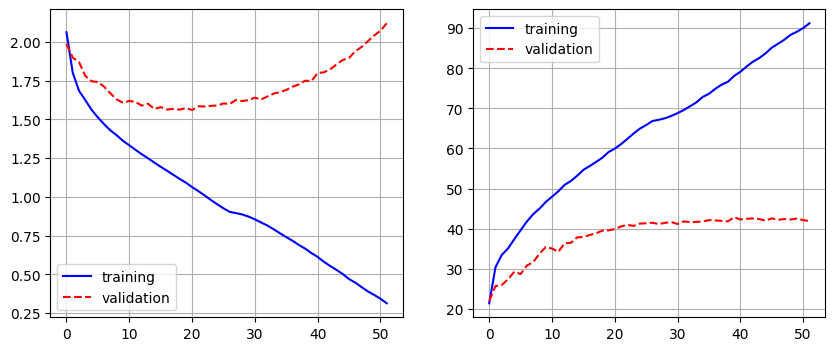

In [126]:
train_loss = history["train_loss"]
train_acc = history["train_acc"]
valid_loss = history["valid_loss"]
valid_acc = history["valid_acc"]
epoch = len(history["train_loss"])

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_loss, 'b', label="training")
ax[0].plot(valid_loss, '--r', label="validation")
ax[0].legend()
ax[0].grid()

ax[1].plot(train_acc, 'b', label="training")
ax[1].plot(valid_acc, '--r', label="validation")
ax[1].legend()
ax[1].grid()
plt.show()

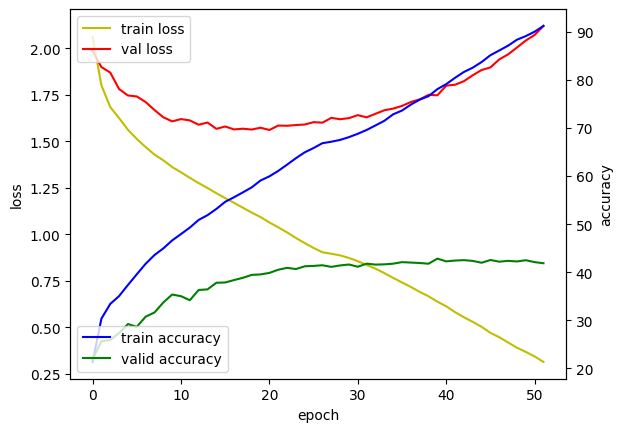

In [113]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history['train_loss'], 'y', label = 'train loss')
loss_ax.plot(history['valid_loss'], 'r', label = 'val loss')

acc_ax.plot(history['train_acc'], 'b', label = 'train accuracy')
acc_ax.plot(history['valid_acc'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [89]:
valid_data_loader

In [159]:
pred, labels = model.predict(valid_x)

  0%|          | 0/52 [00:00<?, ?it/s]

In [127]:
from sklearn.metrics import accuracy_score
accuracy_score(valid_y, pred)

0.8719145093317279

AUC per class: [0.9988048921447856, 0.9975057281920379, 0.9914479879937151, 0.8904236073724547, 0.9986000507038892, 0.9884974479351292]


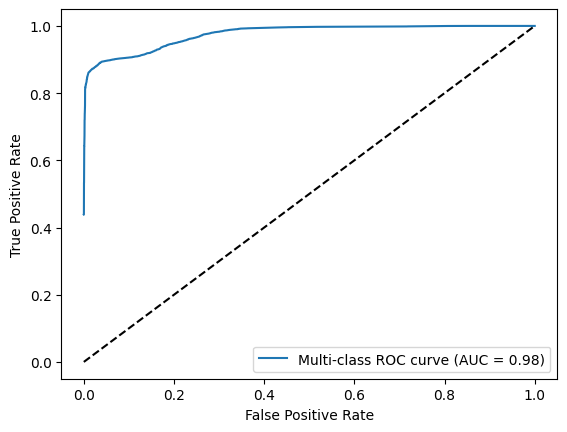

In [148]:
from sklearn.metrics import roc_curve, roc_auc_score

# 예측값과 레이블 값을 가져옵니다.
y_pred = pred.cpu()
y_true = valid_y

# Softmax 함수를 사용하여 확률값을 계산합니다.
y_pred = torch.softmax(y_pred, dim=1)

# 각 클래스에 대한 AUC 값을 계산합니다.
auc_list = []
for i in range(6):
    auc = roc_auc_score((y_true == i), y_pred[:, i].numpy())
    auc_list.append(auc)

# AUC 값을 출력합니다.
print("AUC per class:", auc_list)

# 각 클래스별 FPR과 TPR 값을 구합니다.
fpr_list = []
tpr_list = []
for i in range(6):
    fpr, tpr, _ = roc_curve((y_true == i), y_pred[:, i].numpy())
    fpr_list.append(fpr)
    tpr_list.append(tpr)

# 모든 클래스에 대한 FPR과 TPR 값을 평균 내어 멀티클래스 AUC 값을 구합니다.
mean_fpr = np.unique(np.concatenate(fpr_list))
mean_tpr = np.zeros_like(mean_fpr)
for i in range(5):
    mean_tpr += np.interp(mean_fpr, fpr_list[i], tpr_list[i])
mean_tpr /= 5

# 멀티클래스 AUC-ROC 커브를 그립니다.
plt.plot(mean_fpr, mean_tpr, label='Multi-class ROC curve (AUC = %0.2f)' % np.mean(auc_list))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# history ...

In [169]:
from sklearn.metrics import classification_report
print(classification_report(y_true=valid_y, y_pred=labels.cpu(), target_names=["A1", "A2", "A3", "A4", "A5", "A6"]))

              precision    recall  f1-score   support

          A1       0.94      0.99      0.97      1087
          A2       0.97      0.95      0.96      1331
          A3       0.87      0.98      0.92      1317
          A4       0.99      0.35      0.51      1092
          A5       0.98      0.96      0.97      1056
          A6       0.59      0.99      0.74       761

    accuracy                           0.87      6644
   macro avg       0.89      0.87      0.85      6644
weighted avg       0.91      0.87      0.86      6644

